<a href="https://colab.research.google.com/github/rastringer/unraveling_superposition/blob/main/sparse_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting with Sparse Autoencoders

In [ ]:
!pip install torch transformers

In this notebook, we will explore one of the cutting-edge approaches to interpreting superposition: *sparse autoencoders* (SAE).

SAEs are a type of neural network used in unsupervised learning and feature extraction. Autoencoders are generally useful for detecting patterns that are difficult for humans to discern. SAEs have the following characteristics:

* An encoder to compress data and a decoder to recontruct it
* The SAE enforces sparsity in the hidden layer, activating a small number of neurons for a given input
* This sparsity forces the network to learn more efficient and meaningful representations of the input data
* Trained to minimize reconstruction error
* Useful for feature learning, dimensionality reduction, data denoising



Let's import GPT-2 for examination and set up a simple SAE.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained GPT-2 model
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
gpt2_model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

# Define Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return encoded, decoded



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The following function enables the extraction of activations from GPT-2. The function is liberally commented to explain how to keep track of activations.

Here's how it works:
* Tokenize the text
* Ensure output is a PyTorch tensor
* Return hidden states (activations) from all layers
* `output_hidden_states` is a tuple containing the hidden states from all layers by `layer_idx`, which allows us to choose which layer's activations are of interest.

In [ ]:
# Function to get GPT-2 activations
def get_gpt2_activations(text, layer_idx=-1):
    # Tokenize input text; ensure output is a PyTorch (".pt") tensor
    inputs = tokenizer(text, return_tensors="pt").to(device)
    # Model inference, without tracking gradients. This saves memory,
    # since we are only interested in inference, not training
    with torch.no_grad():
        # The output_hidden_states method returns the hidden states,
        # aka activations, from all layers, not just the final output
        outputs = gpt2_model(**inputs, output_hidden_states=True)
    # outputs.hidden_states is a tuple containing hidden states from
    # all layers of the model. squeeze() removes extra dimensions
    # of size 1 from the tensor.
    return outputs.hidden_states[layer_idx].squeeze()

In [ ]:
def train_sparse_autoencoder(autoencoder, activations, num_epochs=500, sparsity_weight=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        encoded, decoded = autoencoder(activations)

        recon_loss = criterion(decoded, activations)
        sparsity_loss = torch.mean(torch.abs(encoded))
        loss = recon_loss + sparsity_weight * sparsity_loss

        loss.backward()
        optimizer.step()
        scheduler.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return autoencoder

The following visualizations should help explain the findings of the sparse autoencoder. One will show the strength of the activations, the other, learned feature importance.

In [ ]:
def visualize_features(autoencoder, num_features, save_path='learned_features.png'):
    weights = autoencoder.encoder.weight.data.cpu().numpy()
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for i in range(num_features):
        ax = axes[i // 4, i % 4]
        sns.heatmap(weights[i].reshape(1, -1), ax=ax, cmap='viridis', cbar=False)
        ax.set_title(f'Feature {i+1}')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def visualize_activation_strengths(encoded, num_features, save_path='activation_strengths.png'):
    plt.figure(figsize=(12, 6))
    plt.bar(range(num_features), encoded[:num_features])
    plt.title('Activation Strengths of Learned Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Activation Strength')
    plt.xticks(range(0, num_features, 2))  # Label every other feature for readability
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def analyze_superposition(text, hidden_dim=16):
    # Get GPT-2 activations
    activations = get_gpt2_activations(text).to(device)
    input_dim = activations.shape[-1]

    # Initialize and train sparse autoencoder
    autoencoder = SparseAutoencoder(input_dim, hidden_dim).to(device)
    trained_autoencoder = train_sparse_autoencoder(autoencoder, activations)

    # Visualize learned features
    visualize_features(trained_autoencoder, hidden_dim)

    # Analyze activations
    encoded, _ = trained_autoencoder(activations)
    encoded = encoded.mean(dim=0).squeeze().cpu().detach().numpy()

    # Plot activation strengths
    visualize_activation_strengths(encoded, hidden_dim)

    print(f"Analysis complete. Check 'learned_features.png' and 'activation_strengths.png' for visualizations of {hidden_dim} features.")

# Run the analysis with multiple inputs
texts = [
    "It was the best of times, it was the worst of times.",
    # "To be or not to be, that is the question.",
    # "In a hole in the ground there lived a hobbit.",
    # "It was the best of times, it was the worst of times."
]

for i, text in enumerate(texts):
    print(f"\nAnalyzing text {i+1}: '{text}'")
    analyze_superposition(text, hidden_dim=16)


Analyzing text 1: 'It was the best of times, it was the worst of times.'
Epoch [100/500], Loss: 10.9564
Epoch [200/500], Loss: 2.0957
Epoch [300/500], Loss: 1.4265
Epoch [400/500], Loss: 1.3351
Epoch [500/500], Loss: 1.3095
Analysis complete. Check 'learned_features.png' and 'activation_strengths.png' for visualizations of 16 features.


### Learned feature importance

What do we mean by 'features' in this example?

Models such as GPT-2 create a distributed representation of words and concepts. Information about a single word is spread across many dimensions of the model's internal representations, and each dimension contributes to the representation of many different words or concepts.

GPT-2, like many transformer models, uses contextual embeddings, so the representation of a word will change based on its context, eg the word 'bark' in sentences such as 'A dog's bark' and 'The bark on the tree' will have different activations.

The sparse autoeocnder is trying to find efficient ways to encode the patterns in the activations, rather than to isolate individual words.




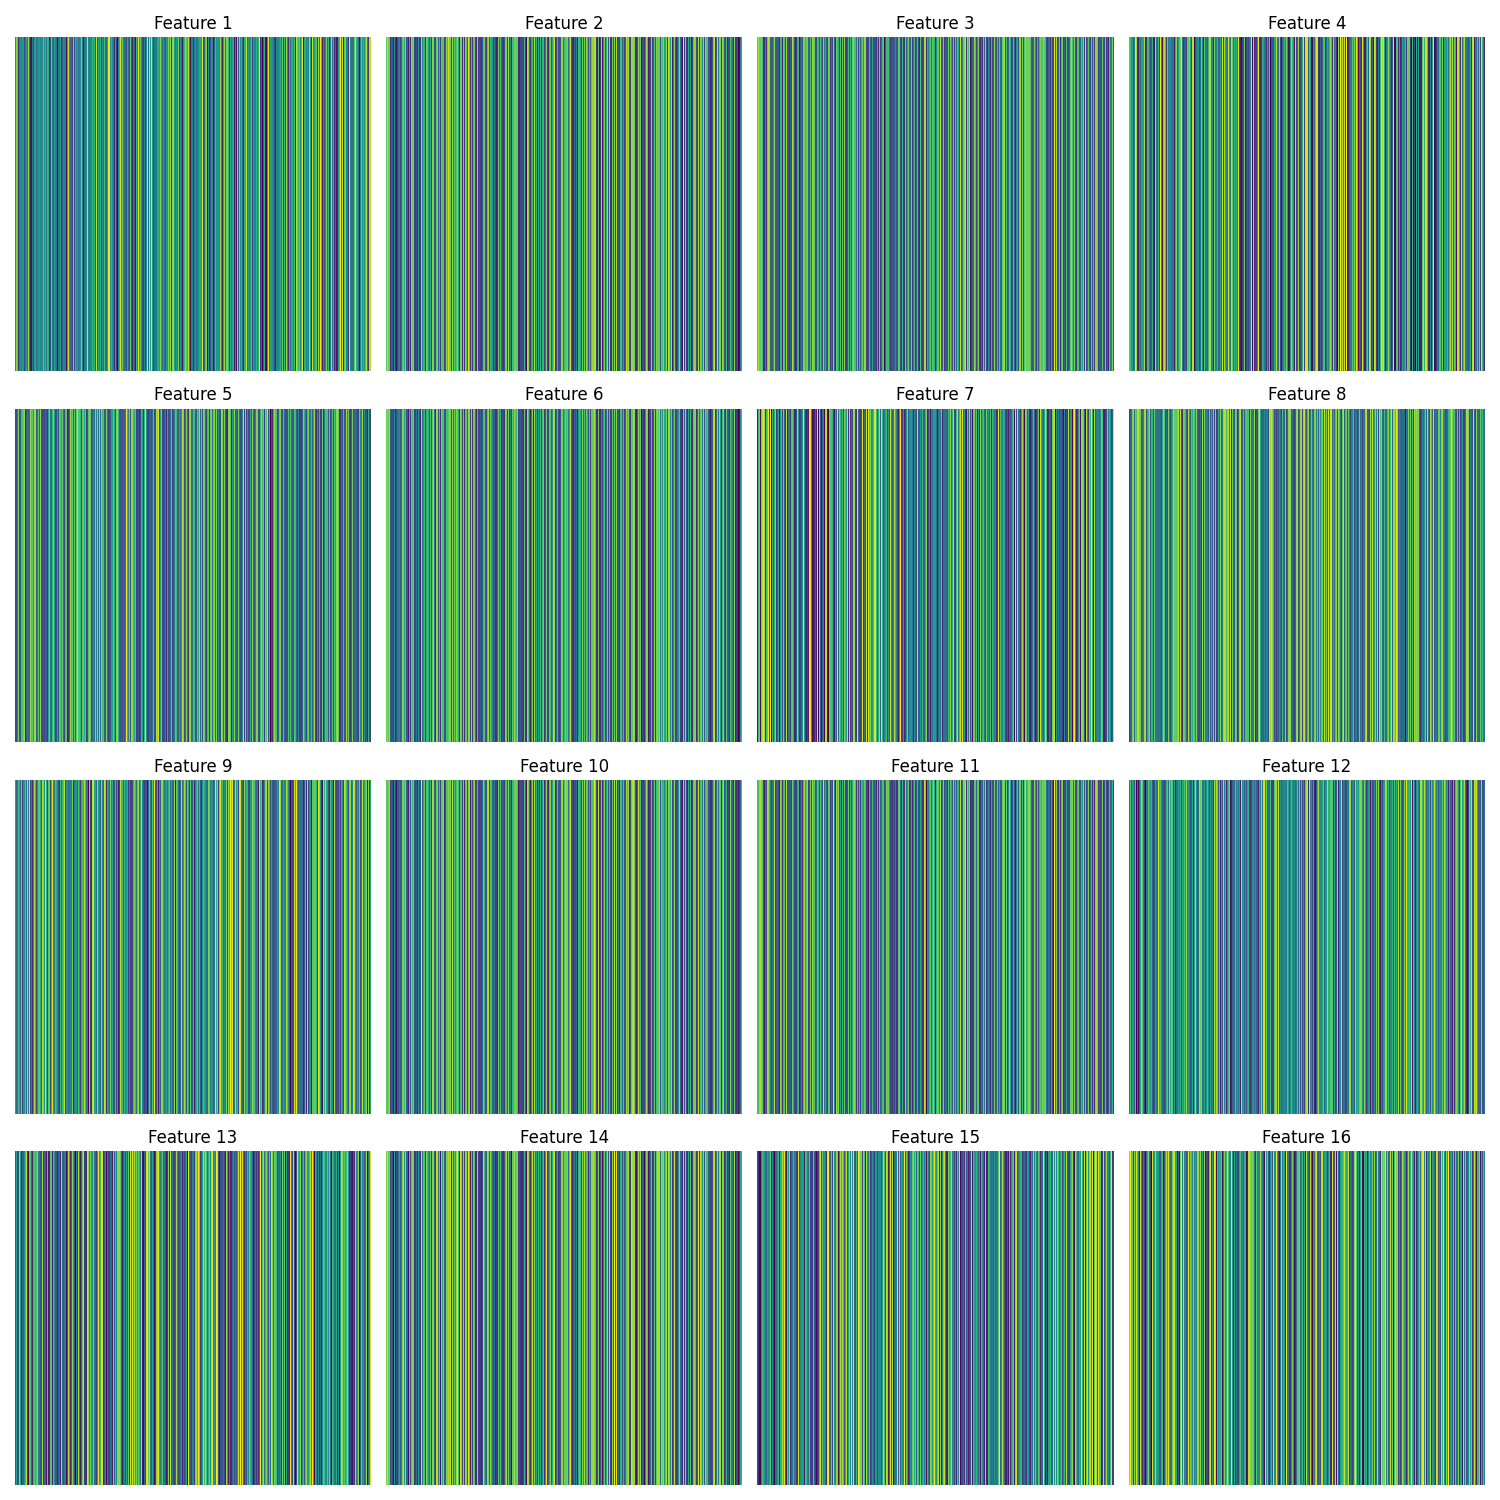

In [ ]:
from IPython.display import Image, display

# Display the image in the notebook
image_path = "learned_features.png"
display(Image(filename=image_path))

### Activation strengths

In this visualization, high activations for some features suggest those features are  particularly relevant to representing the input sentence. The pattern of activations across all features shows how the model is representing the entire input.

Each bar respresents one of the features learned by the SAE, and the height indicates how strongly the feature was activated for the input text.

Look for sparsity: a successful sparse representation will have many features with low activation (shorter bars), only a few will have high activations (tall bars). The overall distribution can give clues about how the autoencoder is representing the information.

In the GPT-2 model, the input text is distributed across all dimensions of its activation vector, so the SAE tries to represent the same information with fewer specific features.

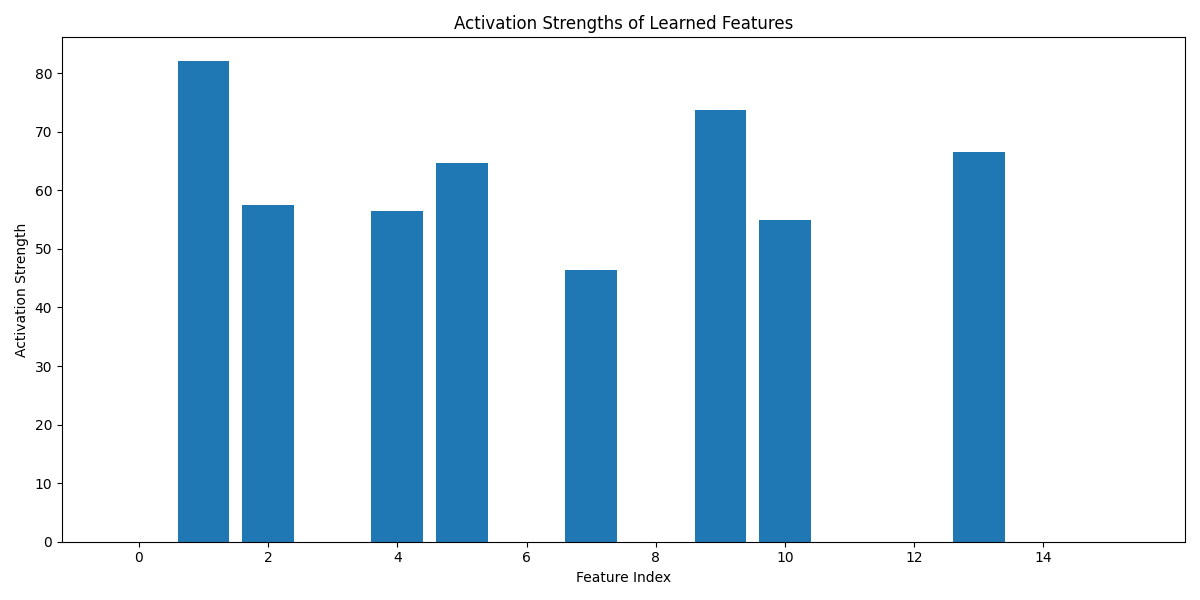

In [ ]:
from IPython.display import Image, display

# Display the image in the notebook
image_path = "activation_strengths.png"
display(Image(filename=image_path))

In considering these two visualizations together, try to correlate the strong activations in the activation strengths with feature patterns in the heatmap.

Look for groups of features that seem to have similar patterns in the heatmap or similar activation levels, which many indicate related aspects of language that GPT-2 represents.

### Summary

This example has shown how in the `learned_features` heatmap how information comprising different linguistic contexts (syntax, semantics etc) is superposed across the same set of neurons in the original model.

In the `activation_strengths` plot, we see how these disentangled features are used to respresent a specific input, with varying levels of activation indicating extracted feature relevance.

The activation of multiple features simultaneously shows how GPT-2 superposes different pieces of information in its dense representation, which the SAE has decomposed into more interpretable units.|